# Logistic Regression and SGD Homework 
***
**Name**: Ahmed Al Hasani
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [2]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [3]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

In [6]:
print("Problem 1.a) Words in Vocab: " + str(len(vocab)))

Problem 1.a) Words in Vocab: 5327


Problem 1.b)

The code is creating features by following the Bag-of-Words Text Model. This is specifically evident with the line of code 
"self.x[vocab.index(word)] += float(count)", which counts the number of times a word is repeated in the text file. Hence, for a given object ex, its list 'x' will hold the frequency/count of words in a given line in a given text file (whether it is from the negative or positive text file). Additionally, the model doesn't follow the binary model, where the list/vector will either have 1's or 0's to indicate whether a word exists in a line or not, we are counting the frequency of the words.

Problem 1.c) 

The positive text file refers to the bike label (1).
The negative text file refers to the car label (0). 

This is evident from reading the text file positive and finding the word "bike" repeated numerous times as opposed to how scarcely "bike" is found in the negative text file. 

### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [18]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        self.iterations = []
        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    self.iterations.append(iteration)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
        return max(self.test_acc)
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        
        # TODO implement LSR updates of weights
        gradient = (self.sigmoid(np.dot(self.w, train_example.x)) - train_example.y)*train_example.x
        self.w = self.w - gradient*self.eta

        shrinkage = 1 - 2*self.eta*self.lam 
        for x_index, x_elem in enumerate(train_example.x):
            #dont grab the bias element, and only regularize non-zero x's
            if x_index != 0 and x_elem > 0.0:
                #initialize feature updated to -1, either it will be changed if x is in last update or it will add to unchaged features
                last_iteration_updated = -1
                if x_index in self.last_update:
                    #Last time feature was updated
                    last_iteration_updated = self.last_update[x_index]
                    #raise Shrinkage Factor to power of no. of iterations since feature was updated
                shrinkage = shrinkage**(iteration - last_iteration_updated)
                #regularize
                self.w[x_index]  = self.w[x_index]*shrinkage
                #store iteration for that feature
                self.last_update[x_index] = iteration

        return self.w 
        

In [19]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(isVerbose=True)

Update     0  TrnNLL  880.873  TstNLL   87.017  TrnA 0.498  TstA 0.534
Update     5  TrnNLL  587.666  TstNLL   62.668  TrnA 0.706  TstA 0.724
Update    10  TrnNLL  630.383  TstNLL   66.444  TrnA 0.682  TstA 0.707
Update    15  TrnNLL  559.246  TstNLL   58.871  TrnA 0.718  TstA 0.767
Update    20  TrnNLL  542.703  TstNLL   55.050  TrnA 0.756  TstA 0.741
Update    25  TrnNLL  515.403  TstNLL   54.344  TrnA 0.772  TstA 0.750
Update    30  TrnNLL  502.789  TstNLL   53.166  TrnA 0.777  TstA 0.784
Update    35  TrnNLL  685.808  TstNLL   72.709  TrnA 0.651  TstA 0.672
Update    40  TrnNLL  512.530  TstNLL   54.816  TrnA 0.754  TstA 0.759
Update    45  TrnNLL  455.235  TstNLL   45.167  TrnA 0.797  TstA 0.845
Update    50  TrnNLL  412.981  TstNLL   40.363  TrnA 0.839  TstA 0.879
Update    55  TrnNLL  408.755  TstNLL   41.873  TrnA 0.841  TstA 0.828
Update    60  TrnNLL  387.590  TstNLL   39.614  TrnA 0.858  TstA 0.879
Update    65  TrnNLL  364.139  TstNLL   38.807  TrnA 0.866  TstA 0.879
Update

Update   590  TrnNLL  126.629  TstNLL   19.507  TrnA 0.963  TstA 0.931
Update   595  TrnNLL  125.650  TstNLL   19.186  TrnA 0.965  TstA 0.922
Update   600  TrnNLL  122.270  TstNLL   19.746  TrnA 0.971  TstA 0.931
Update   605  TrnNLL  118.056  TstNLL   19.807  TrnA 0.967  TstA 0.931
Update   610  TrnNLL  118.548  TstNLL   19.780  TrnA 0.968  TstA 0.931
Update   615  TrnNLL  119.832  TstNLL   20.232  TrnA 0.968  TstA 0.931
Update   620  TrnNLL  119.404  TstNLL   20.044  TrnA 0.969  TstA 0.931
Update   625  TrnNLL  119.342  TstNLL   20.932  TrnA 0.970  TstA 0.931
Update   630  TrnNLL  126.465  TstNLL   23.078  TrnA 0.964  TstA 0.914
Update   635  TrnNLL  125.891  TstNLL   22.908  TrnA 0.965  TstA 0.914
Update   640  TrnNLL  109.049  TstNLL   17.864  TrnA 0.975  TstA 0.948
Update   645  TrnNLL  109.836  TstNLL   17.549  TrnA 0.976  TstA 0.948
Update   650  TrnNLL  106.865  TstNLL   17.456  TrnA 0.976  TstA 0.948
Update   655  TrnNLL  106.454  TstNLL   17.150  TrnA 0.977  TstA 0.948
Update

0.9568965517241379

The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [51]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [50]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

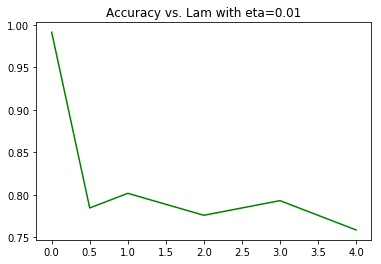

Lam Values: [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]
Corresponding Accuracies: [0.9913793103448276, 0.7844827586206896, 0.8017241379310345, 0.7758620689655172, 0.7931034482758621, 0.7586206896551724]
Lam Value with highest accuracy: 0.0
Accuracy: 0.9913793103448276


In [53]:
def lam(train_set, test_set):
    lam_values = [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]
    lam_accuracies = []
    for x in lam_values:
        model = LogReg(train_set, test_set, lam = x, eta = 0.01)
        lam_accuracies.append(model.train())

    plt.title("Accuracy vs. Lam with eta=0.01")
    plt.plot(lam_values, lam_accuracies, color='g')
    plt.show()
    print("Lam Values:", end=" ")
    print(lam_values)
    print("Corresponding Accuracies:", end=" ")
    print(lam_accuracies)
    print("Lam Value with highest accuracy: " + str(lam_values[lam_accuracies.index(max(lam_accuracies))]))
    print("Accuracy: " + str(max(lam_accuracies)))
    return lam_values[lam_accuracies.index(max(lam_accuracies))]

max_lam = lam(train_set, test_set)

The lam value that results in the highest accuracy is 0.0. The code above creates a model object each time it passes a different lam value from the list of lam values I created [0.0, 0.5, 1.0, 2.0, 3.0, 4.0], while keeping the eta constant at 0.01 with the same train set and test set. When the model is trained, it returns the highest accuracy recorded for the test set, which computes accuracy for every 5 iterations. The corresponding accuracy for 0.0 ranges betwen 96% and 99%, depending on random() (if the function or cell block is executed seperately from the whole notebook). The line graph plotted shows the various accuracies for the different lam values tested.

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

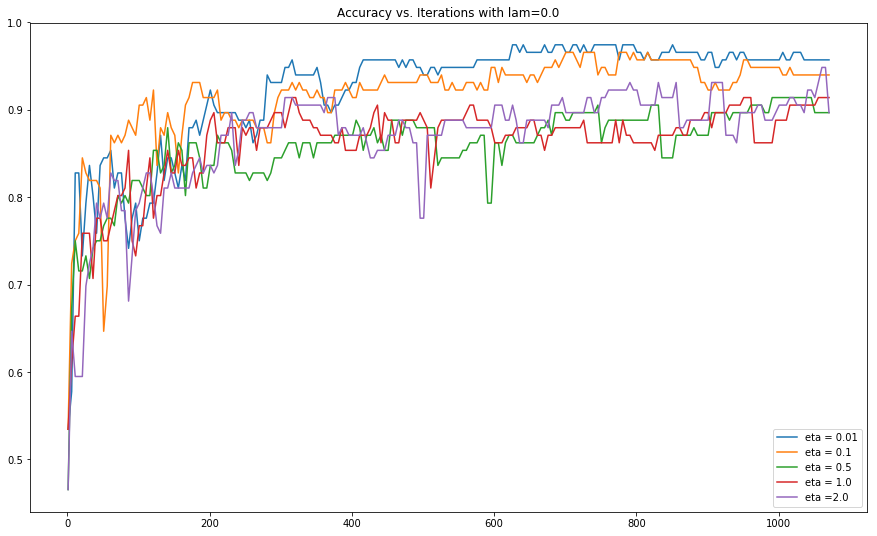

ETA Value with highest accuracy: 0.01
Accuracy: 0.9741379310344828


In [49]:
def eta(train_set, test_set, max_lam): 
    eta_values = [0.01, 0.1, 0.5, 1.0, 2.0]
    eta_accuracies = []
    fig = plt.figure(figsize=(15, 9))
    for x in eta_values:
        model = LogReg(train_set, test_set, lam = max_lam, eta = x)
        model.train()
        plt.plot(model.iterations, model.test_acc)
        eta_accuracies.append(max(model.test_acc))
    plt.title("Accuracy vs. Iterations with lam=0.0")
    plt.legend(['eta = 0.01', 'eta = 0.1', 'eta = 0.5', 'eta = 1.0', 'eta = 2.0'], loc='lower right')
    plt.show()
    print("ETA Value with highest accuracy: " + str(eta_values[eta_accuracies.index(max(eta_accuracies))]))
    print("Accuracy: " + str(max(eta_accuracies)))
model = eta(train_set, test_set, max_lam)

Per part A, the highest accuracy is given by a lam value of 0.0. For my study, I created a list of ETA values which include = [0.01, 0.1, 0.5, 1.0, 2.0]. The ETA value that results in the highest accuracy most of the time when the above cell is ran, is 0.01, it is also the eta value that converges the earliest. It converges to a value very close to its maximum accuracy most of the time, the earliest. In rare situations, the eta value 0.1 records the highest accuracy, but it does not converge earlier than the eta value of 0.01, it still fluctuates and changes until later late iterations, later than the iterations eta 0.01 requires.

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [40]:
def top_words(train_set, test_set):
    model = LogReg(train_set, test_set, lam = 0.0, eta = 0.01)
    model.train()
    k = model.w
    top_ten = k.argsort()[-10:][::-1] #grab indices of highest ten elements
    top_ten_words = []
    top_ten_weights = []
    for element in top_ten:
        top_ten_weights.append(k[element])
        top_ten_words.append(vocab[element])
    print("Best Motorcycles Predictors")
    print(top_ten_words)
    print(top_ten_weights)

def top_words2(train_set, test_set):
    model = LogReg(train_set, test_set, lam = 0.0, eta = 0.01)
    model.train()
    k = model.w
    least_ten = k.argsort()[:10] #grab indices of least ten elements
    least_ten_words = []
    least_ten_weights = []
    for element in least_ten:
        least_ten_weights.append(k[element])
        least_ten_words.append(vocab[element])
    print("Best Automobile Predictors")
    print(least_ten_words)
    print(least_ten_weights)

top_words(train_set, test_set)
top_words2(train_set, test_set)

Best Bike Predictors
['bike', 'dod', 'bikes', 'ride', 'riding', 'rider', 'sun', 'helmet', 'dog', 'ca']
[0.72227085520131462, 0.62595793319679194, 0.29431211178951322, 0.26270531065245067, 0.25478295210831797, 0.2230089737190864, 0.18877718564269763, 0.18732801180384911, 0.17534629623199999, 0.17032422061267738]
Best Car Predictors
['car', 'cars', 'engine', 'dealer', 'ford', 'usa', 'oil', 'toyota', 'warning', 'wagon']
[-0.72316180560968357, -0.41268474762989066, -0.17927502228958248, -0.16699850491983348, -0.16352975975765871, -0.16029807065583374, -0.15873022390659433, -0.1473675313194637, -0.13040601684489048, -0.12168562153386263]


The top ten words for the positve class, motorcycle, will have the top ten highest weights in the W vector. On the other hand, the top ten words for the negative class, automobile, will have the least weights in the W vector, they have negative weights. The highest words will help raise the probability computed from the sigmoid function as close as possible to 1, which indicates that the label is highly likely to be a motorcycle. Consequently, the highest words for the automobile class will help decrease the probability computed in the sigmoid function as low as possible to 0, which indicates its highly likely that it is an automobile. It is important to note that the word 'bike' has a weight ~ 0.7, whereas the word 'car' has a weight of ~-0.7, these are the best predictors in their classes, as one can guess, if these words are found in a vector/list x, they can significantly shift the probability to either 1 or 0, depends on which one is found. 

**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [41]:
import math
def worst_predictors_1(train_set, test_set):
    model = LogReg(train_set, test_set, lam = 0.0, eta = 0.01)
    model.train()
    w = model.w
    w[w < 0] = math.inf #change weights that are negative to +ve infinity, for the line below to work
    least_ten = w.argsort()[:10] #grab the index of the least 10 words
    top_ten_words = []
    top_ten_weights = []
    for elemnet in least_ten:
        top_ten_weights.append(w[elemnet])
        top_ten_words.append(vocab[elemnet])
    print("Worst Motorcycles Predictors")
    print(top_ten_words)
    print(top_ten_weights)

def worst_predictors_0(train_set, test_set):
    model = LogReg(train_set, test_set, lam = 0.0, eta = 0.01)
    model.train()
    w = model.w
    w[w > 0] = -math.inf #change weights that are negative to -ve infinity, for the line below to work
    top_ten = w.argsort()[-10:][::-1] #grab the index of the highest 10 values
    top_ten_words = []
    top_ten_weights = []
    for elemnet in top_ten:
        top_ten_weights.append(w[elemnet])
        top_ten_words.append(vocab[elemnet])
    print("Worst Automobile Predictors")
    print(top_ten_words)
    print(top_ten_weights)
    
worst_predictors_1(train_set, test_set)
worst_predictors_0(train_set, test_set)

Worst Bike Predictors
['felt', 'legality', 'walls', 'switches', 'medical', 'positions', 'redwood', 'begin', 'traded', 'sometime']
[1.2704803502838621e-05, 1.2899850724492614e-05, 2.5544731337033425e-05, 5.0451581723216224e-05, 5.4809092330424403e-05, 7.6833938550837093e-05, 7.8926078561130687e-05, 7.9325312450977245e-05, 8.562306689306371e-05, 9.2628327984695103e-05]
Worst Car Predictors
['sounding', 'obey', 'towing', 'traded', 'sake', 'separated', 'goodyear', 'bulletin', 'logic', 'infrastructure']
[-6.50122946979831e-09, -9.1730243701552097e-08, -1.4882454257242557e-07, -2.8229940066322343e-06, -8.2485880874186941e-06, -8.5909004086182307e-06, -9.2097302126260912e-06, -1.1718929322892917e-05, -1.4482882557038858e-05, -1.6345022085328866e-05]


The worst predictors have weights that hover around 0 weight as close as possible, and this applies for both classes. Weights that are really close to 0 that are positive numbers are the worst predictors for the motorcycle class, and weights that are really close to 0 that are negative are the worst predictors for the automobile class. These words compute probabilities that are inconclusive (~50%), where we might as well can classify a feature to be either a motorcycle or automobile just by flipping a coin. It is important to note that their weights are so small, they have a power magniute of 10^-5 (both negative and positive weights). 